In [1]:
# LDEO released LVS data in SEGY format
# I want to at least grab the traces for an updated map

In [2]:
# I also tried segyio from Equinor, but pip install failed and building from source turned into a pain
import segpy
import segpy.reader

In [59]:
import matplotlib.pyplot as plt
import numpy as np
import os

In [71]:
radar_line = "X20a"
filepath = "/Volumes/QIceRadar01/ANTARCTIC/SOAR/LVS/{}.segy".format(radar_line)
nav_filepath = "/Volumes/QIceRadar01/ANTARCTIC/SOAR/LVS/vostok_radar_nav_lines/{}.nav".format(radar_line)
os.path.exists(filepath), os.path.exists(nav_filepath)

(True, True)

In [68]:
with open(filepath, 'rb') as infile:
    segy_reader = segpy.reader.create_reader(infile, endian='>')
    #print(dir(segy_reader))
    print("We have {} traces".format(segy_reader.num_traces()))
    print("And {} bytes per sample".format(segy_reader.bytes_per_sample))
    print("Data sample format: {}".format(segy_reader.data_sample_format_description))
    print("revision: {}".format(segy_reader.revision))
    print("dimensionality: {}".format(segy_reader.dimensionality))
    print("encoding: {}".format(segy_reader.encoding))
    print("endian: {}".format(segy_reader.endian))
    num_samples = segy_reader.max_num_trace_samples()
    print("max number of trace samples: {}".format(num_samples))
    print("... and {} samples in first trace".format(segy_reader.num_trace_samples(0)))

    num_traces = segy_reader.num_traces()
    print("number of traces: {}".format(num_traces))
    
    #print(segy_reader.trace_samples(0))
    sample0 = list(map(int, segy_reader.trace_samples(0)))
    print("The first trace has {} samples, with min = {} and max = {}".format(len(sample0), np.min(sample0), np.max(sample0)))
    
    # I'm not sure why these give errors -- is the datafile corrupt? not supported? the wrong format?
    #print(help(segy_reader.trace_header))
    #print(segy_reader.trace_header(0))
    print(segy_reader.trace_header_format_class)
        
    radargram = np.zeros((num_traces, num_samples))
    for ii in range(num_traces):
        radargram[ii,:] = list(map(int, segy_reader.trace_samples(ii)))
        
    

We have 11936 traces
And 4 bytes per sample
Data sample format: IBM 32 bit float
revision: 0
dimensionality: 0
encoding: cp037
endian: >
max number of trace samples: 4096
... and 4096 samples in first trace
number of traces: 11936
The first trace has 4096 samples, with min = -42809 and max = 61239
<class 'segpy.trace_header.TraceHeaderRev1'>


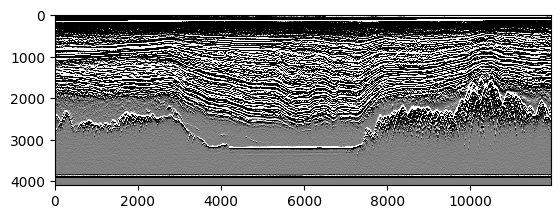

In [69]:
plt.imshow(radargram.transpose(), clim=[-200, 200], cmap='gray')


In [62]:
radargram

array([[190., 180., 174., ...,   0.,   0.,   0.],
       [188., 145., 140., ...,   0.,   0.,   0.],
       [191., 189., 147., ...,   0.,   0.,   0.],
       ...,
       [138., 102., 121., ...,   0.,   0.,   0.],
       [145.,  81., 145., ...,   0.,   0.,   0.],
       [ 15.,  81., 132., ...,   0.,   0.,   0.]])

OK, looks like I've figured out how to plot the radargrams.
However, I'm still missing how to georeference this data; 
presumably that data belongs in the trace_header, but I'm not able to access it.

In [72]:
traces = []
latitudes = []
longitudes = []
elevations = []
for line in open(nav_filepath, "r"):
    _, trace, lon, lat, elev = line.split()
    traces.append(int(trace))
    longitudes.append(float(lon))
    latitudes.append(float(lat))
    elevations.append(float(elev))
    

In [80]:
import pyproj
import shapefile as shp

In [74]:
ps71 = pyproj.Proj('epsg:3031')

In [75]:
xx, yy = ps71(longitudes, latitudes)

In [81]:
gl_filepath = "/Users/lindzey/Data/Quantarctica3/Glaciology/ASAID/ASAID_GroundingLine_Simplified.shp"

# If I do it this way, I can plot as points (but not lines!). This is easier than having to iterate through each segment.
sf = shp.Reader(gl_filepath)
gl_xx = []
gl_yy = []
for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    gl_xx.extend(x)
    gl_yy.extend(y)

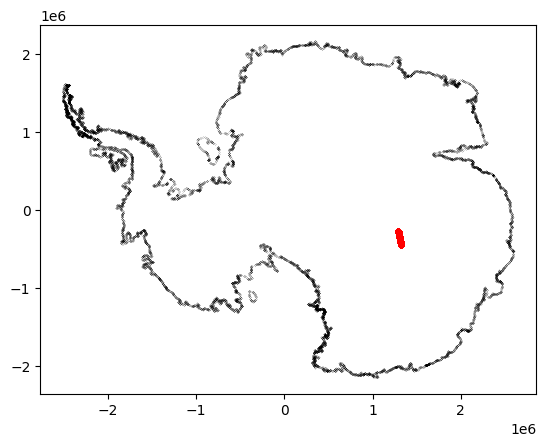

In [83]:
plt.plot(gl_xx, gl_yy, 'k.', markersize=0.2)
plt.plot(xx, yy, 'r.')